## 36LABS - Agent Creator
Google x Kaggle AI Agents Intensive Capstone Project

Author: **Sukesh Tallapudi**

## Section1: Project Overview

### Project Statement

The pace of AI innovation has accelerated dramatically. Users have highly specific, ever-changing needs shaped by their work, environment, and workflows. No single AI tool or even a massive catalogue of them can cover the infinite variety of user requirements. In such a fast-moving landscape, individuals and organisations must be able to create AI agents tailored to their exact tasks. This creates the need for an interface where users serve as architects while agents handle execution. **36Labs** fills this gap by providing a unified master agent that builds custom tools or agents directly from user requirements.

### Track and Features

This project aligns best with the **Freestyle Track**, as its core concept is broad, flexible, and difficult to confine to a single category. 36Labs is inherently innovative, enabling users to create arbitrary AI tools and agents tailored to tackle real-world needs (Agents for Good), optimising organisational workflows (Enterprise Agents), or delivering highly personalised assistance (Concierge Agents).

The system incorporates multiple agentic features, including a coordinated multi-agent architecture, both built-in and custom tool integrations, robust session management, long-term memory, adherence to the A2A protocol, and end-to-end agent deployment.

### Setup
This notebok requires pior installation of Google Agent Development Kit (ADK) package and both the API Keys to use the Gemini model and Gooogle Cloud need to be configured. The following few lines of code configures the API keys and import the necessary modules.

In [1]:
#pip install google-adk
import os
import random
import time
import vertexai
from kaggle_secrets import UserSecretsClient
from vertexai import agent_engines

print("✅ Imports completed successfully")
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Imports completed successfully
✅ Gemini API key setup complete.


This cell retrieves your Google Cloud credentials from Kaggle Secrets and configures them for use. These credentials allow the notebook to authenticate with Google Cloud services like Vertex AI Agent Engine.

In [2]:
# Set up Cloud Credentials in Kaggle
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

print("✅ Cloud credentials configured")

✅ Cloud credentials configured


### Set your PROJECT_ID
Make sure to replace "your-project-id" with your actual Google Cloud project ID.

In [ ]:
## Set your PROJECT_ID
PROJECT_ID = "your-project-id" # Replace with your project ID 
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

if PROJECT_ID == "your-project-id" or not PROJECT_ID:
    raise ValueError("⚠️ Please replace 'your-project-id' with your actual Google Cloud Project ID.")

print(f"✅ Project ID set to: {PROJECT_ID}")

### Create agent directory
We need a clean workspace to package our agent for deployment. We will create a directory named sample_agent.

All necessary files - including the agent code, dependencies, and configuration—will be written into this folder to prepare it for the `adk deploy` command.

In [4]:
## Create simple agent - all code for the agent will live in this directory
!mkdir -p sample_agent

print(f"✅ Sample Agent directory created")

✅ Sample Agent directory created


### Create requirements file
The Agent Engine builds a dedicated environment for your agent. To ensure it runs correctly, we must declare our dependencies.

We will write a `requirements.txt` file containing the Python packages needed for the agent.

In [5]:
%%writefile sample_agent/requirements.txt
## Creates a requirements.txt file in this directory

google-adk
opentelemetry-instrumentation-google-genai

Writing sample_agent/requirements.txt


### Create environment configuration
We need to provide the agent with the necessary cloud configuration settings.

We will write a `.env` file that sets the cloud location to global and explicitly enables the Vertex AI backend for the ADK SDK.

In [7]:
%%writefile sample_agent/.env
# https://cloud.google.com/vertex-ai/generative-ai/docs/learn/locations#global-endpoint
GOOGLE_CLOUD_LOCATION="us-central1"  # Choose the nearest location, for example, "asia-south1" for Mumbai, India

# Set to 1 to use Vertex AI, or 0 to use Google AI Studio
GOOGLE_GENAI_USE_VERTEXAI=1

Writing sample_agent/.env


### Further imports

In [8]:
#%%writefile 36Labs_agent/agent.py
from google.adk.agents import Agent, LlmAgent
from google.adk.apps.app import App, EventsCompactionConfig
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import google_search
from typing import List, Dict, Any
from google.genai import types
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.sessions import DatabaseSessionService
from google.adk.runners import Runner
from google.adk.tools.tool_context import ToolContext
from google.genai import types
from google.adk.a2a.utils.agent_to_a2a import to_a2a
from google.adk.agents.remote_a2a_agent import (
    RemoteA2aAgent,
    AGENT_CARD_WELL_KNOWN_PATH,
)
import json
import requests
import subprocess
import time
import uuid

print("✅ Imports completed successfully")

#print("✅ ADK components imported successfully.")

✅ Imports completed successfully


### Helper Functions
We'll define some helper functions. If you are running this outside the Kaggle environment, you don't need to do this. This allows users to use the ADK Web Interface and for session management.

In [9]:
# Define helper functions that will be reused throughout the notebook

from IPython.core.display import display, HTML
from jupyter_server.serverapp import list_running_servers


# Gets the proxied URL in the Kaggle Notebooks environment
def get_adk_proxy_url():
    PROXY_HOST = "https://kkb-production.jupyter-proxy.kaggle.net"
    ADK_PORT = "8000"

    servers = list(list_running_servers())
    if not servers:
        raise Exception("No running Jupyter servers found.")

    baseURL = servers[0]["base_url"]

    try:
        path_parts = baseURL.split("/")
        kernel = path_parts[2]
        token = path_parts[3]
    except IndexError:
        raise Exception(f"Could not parse kernel/token from base URL: {baseURL}")

    url_prefix = f"/k/{kernel}/{token}/proxy/proxy/{ADK_PORT}"
    url = f"{PROXY_HOST}{url_prefix}"

    styled_html = f"""
    <div style="padding: 15px; border: 2px solid #f0ad4e; border-radius: 8px; background-color: #fef9f0; margin: 20px 0;">
        <div style="font-family: sans-serif; margin-bottom: 12px; color: #333; font-size: 1.1em;">
            <strong>⚠️ IMPORTANT: Action Required</strong>
        </div>
        <div style="font-family: sans-serif; margin-bottom: 15px; color: #333; line-height: 1.5;">
            The ADK web UI is <strong>not running yet</strong>. You must start it in the next cell.
            <ol style="margin-top: 10px; padding-left: 20px;">
                <li style="margin-bottom: 5px;"><strong>Run the next cell</strong> (the one with <code>!adk web ...</code>) to start the ADK web UI.</li>
                <li style="margin-bottom: 5px;">Wait for that cell to show it is "Running" (it will not "complete").</li>
                <li>Once it's running, <strong>return to this button</strong> and click it to open the UI.</li>
            </ol>
            <em style="font-size: 0.9em; color: #555;">(If you click the button before running the next cell, you will get a 500 error.)</em>
        </div>
        <a href='{url}' target='_blank' style="
            display: inline-block; background-color: #1a73e8; color: white; padding: 10px 20px;
            text-decoration: none; border-radius: 25px; font-family: sans-serif; font-weight: 500;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2); transition: all 0.2s ease;">
            Open ADK Web UI (after running cell below) ↗
        </a>
    </div>
    """

    display(HTML(styled_html))

    return url_prefix


async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")



print("✅ Helper functions defined.")

✅ Helper functions defined.


### Configure Retry Options
When working with LLMs, you may encounter transient errors like rate limits or temporary service unavailability. Retry options automatically handle these failures by retrying the request with exponential backoff.

In [10]:
#%%writefile 36Labs_agent/agent.py
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1, # Initial delay before first retry (in seconds)
    http_status_codes=[429, 500, 503, 504] # Retry on these HTTP errors
)

### Section 2: The Implmentation

To keep 36Labs intuitive for users, its architecture is designed to be simple and transparent, with each sub-agent named directly after its function.The user first interacts with the `questionnaire_agent` to express their intent. Using the built-in _google_search_ tool, this agent gathers context and asks targeted (particular number of) questions to clarify the user’s needs. This structured inquiry helps the user articulate precise requirements, forming the foundation for all subsequent stages in the agent’s architecture.

### How it Works?
To create any agent, user must send his request first. Then the questionarre_agent responds to user by asking a set of questions, which allows user to answer by providing their set of requirments. In order to make agent remember the context, the `DatabaseSessionService` is used to run queries.

In [ ]:
#%%writefile 36Labs_agent/agent.py

APP_NAME = "default"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session
MODEL_NAME = "gemini-2.5-flash-lite" #Model

# Define the Agent
questionarre_agent = LlmAgent(
    name="questionarre",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="An agent that asks questions to the user about the customary agent needed to be created",
    instruction=( 
        "You receive the request from the user regarding the agent creation. Your task is to perform a google search"
        "and list down all the possible questions (**must** be less than **THREE**) and details required for a satisfactory MVP of the customary agent requested by the user"
        "Make sure to ask details about the preferred way of communication between the agent and user and the details (like credentials, APIs etc) to process that "
    ), #We chose to just ask THREE questions. Feel free to vary the number according to the requirements.
    output_key = "questionarre_list",
    tools=[google_search]
)

# SQLite database will be created automatically
db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)

In [ ]:
#%%writefile 36Labs_agent/agent.py
# Create a new runner with persistent storage
runner = Runner(agent=questionarre_agent, app_name=APP_NAME, session_service=session_service)
await run_session(
    runner,
    ["STATE YOUR REQUEST HERE"], # For example, I want to create an agent which can send auto replies to customer complaints
    SESSION,
)

### Workflow_agent Implementation

Now the user will provide their set of requirements, which acts as basis to build an agent. The `workflow_agent` is implemented as a **SequentialAgent**, comprising two sub-agents: `memory_agent` and `strategy_agent`.

### memory_agent
This agent formats the user's response into a dictionary. It uses the custom tool, **record_user_answer** format and later store within the predefined dictionary `{user_data_store}`. The outcome of the agent, under the key, "user_requirements" is essential for the next agent.

### strategy_agent
This organised data enables the strategy_agent to design an effective outline for building the requested tool or agent. It then produces a second dictionary, `{workflow}`, using the custom tool, **agent_outline** which captures the complete plan. This structured flow of information ensures that the manager_agent receives clear, actionable instructions to execute and build the final product. As mentioned earlier, the DatabaseSessionService is used to run queries.


In [ ]:
#%%writefile 36Labs_agent/agent.py
# External Memory Store
user_data_store = {}
def record_user_answer(question_key: str, answer: str) -> str:
    """Saves the user's answer into the persistent memory store."""
    user_data_store[question_key] = answer
    return f"Successfully recorded answer for '{question_key}'."

# Define the Agent
memory_agent = Agent(
    name="data_collector",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="An agent that formats questions and records the user's answer using the record_user_answer tool.",
    instruction=(
        "You need to format (dont summarise because that might lead the essential information) the user request"
        "to update the values of keys in a predefined dictionary, 'user_data_store' "
        "you *must* use the `record_user_answer` tool and update the 'user_data_store' dictionary to update the question's topic "
        "as the `question_key` and the user's response as the `answer`."
        "and *must* also return the formatted response as your output "
    ),
    output_key = "user_requirements",
    tools=[record_user_answer]
)

In [ ]:
#%%writefile 36Labs_agent/agent.py
#Workflow
workflow = {}
def agent_outline(index: str, answer: str) -> str:
    """Saves the user's answer into the persistent memory store."""
    workflow[index] = answer
    return f"Successfully recorded answer for '{index}'."
# Define the Agent
strategy_agent = Agent(
    name="strategy_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="An agent that creates a strategy and workflow to create an agent",
    instruction=( 
        "First, you **must** read the user requirements: {user_requirements}"
        "and understand the motivation and requirments of the agent to be created"
        "Remember, you **must** not ask anymore questions, you just need to use the information provided."
        "Then you need to come up with a strategy to develop an AI agent using google_adk pacakge, in a **step-wise workflow**."
        "Make sure you need to produce the workflow within **THREE** steps"
        "Remember, the strategy is to create a COMPLETE Google ADK agent that:\n"
        "    - **Must** defines an Agent() from  Google_ADK pacakge which includes pre-defined tools. First create the required tools and then define an agent using those tools"
        "you *must* use the 'agent_outline' tool and update the 'workflow' dictionary"
        "where keys are integers and values are the workflow steps written as short, clear strings"
        "and *must* also return the formatted response as your output "
        "For example, a sample output will be {1:'a',2:'b',3:'c'} "
    ), #We chose to just ask THREE steps. Feel free to vary the number according to the requirements.
    output_key = "workflow_outline",
    tools=[agent_outline]
)

#SequentialAgent Definition
workflow_agent = SequentialAgent(
    name = "memory_strategy_agent",
    sub_agents = [memory_agent, strategy_agent]
)



In [ ]:
#%%writefile 36Labs_agent/agent.py
runner = Runner(agent=workflow_agent, app_name=APP_NAME, session_service=session_service)

await run_session(
    runner,
    ["USER SHARE THEIR REQUIREMENTS HERE BY ANSWERING QUESTIONS FROM QUESTIONARRE_AGENT"],
    SESSION,
)

In [ ]:
#%%writefile 36Labs_agent/agent.py
print(workflow)

### Manager_agent Implementation

As the root agent of 36Labs, the `manager_agent` is responsible for developing the code, testing and refining it, until the final product is achieved, thereby managing the entire workflow. Implemented as a **SequentialAgent**, it consists of two key components: a developer_agent and a **LoopAgent**, test_debug_agent.

### developer_agent
The `developer_agent` is responsible for generating the initial draft of the code. For every sequential task defined in the {workflow dictionary}, this agent is invoked to produce the corresponding preliminary implementation. Once generated, each draft is stored in a dedicated dictionary, `{code_store}`, using custom tool **save_code** designed for safe and organised code handling. Within the dictionary, the keys represent individual workflow steps and the values contain the code produced for each step. In contrast to the earlier steps, no special session services are used to run this agent. The outcome of the agent, under the key, "draft_code" is essential for the next agent.

In [ ]:
#%%writefile 36Labs_agent/agent.py
code_store = {}
def save_code(step: int, code: str) -> str:
    """
    Saves generated Python code for a given workflow step (into code_store).
    """
    code_store[step] = code
    return f"Code saved successfully for step {step}."


developer_agent = Agent(
    name="developer_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="This agent writes Python code for a given task using Google ADK.",
    instruction=(
        "You are the Developer Agent.\n"
        "You will receive:\n"
        "- Clear decription of your task containing all the requirements"
        "- And the 'step' value"
        "Your job:\n"
        "- Code must contain documentation/comments.\n"
        "- Finally, code must BE in PYTHON SCRIPT AND READBLE FORMAT .\n"
        ''' - **YOU MUST NOT** include "if __name__ == '__main__'" blocks .\n '''
        "Do NOT include placeholder print/logic not tied to final agent .\n"
        "ALWAYS generate python code in functions or classes only .\n"
        "Code MUST be importable and modular (no top-level logic) .\n"
        "When asked, you should build an AI agent Code using google_adk pacakge. Code MUST follow Google ADK structure where relevant.\n"
        "OUTPUT :\n"
        "- Firstly Output using the `save_code` tool.\n"
        "- Then you **MUST** also return the same code as your output"
    ),
    output_key = "draft_code", 
    tools=[save_code],
)

### test_debug_agent

Implemented as a LoopAgent, the test_debug_agent consists of two sub-agents: tester_agent and debug_agent.

### tester_agent
`tester_agent` receives the "draft_code" and focuses solely on identifying issues rather than rewriting it. A built-in tool, **analyze_code**, is used to highlight potential errors in structure, format, or logic, defined in prior within the function. All detected issues are then recorded in an `{error_store dictionary}` using the same tool, where each entry corresponds to a specific workflow step. Once documented, the errors are passed to the debug_agent for further action. No special session services are used to run this agent and the outcome of the agent is under the key, "error_list".

### debug_agent
Based on the tester_agent’s feedback, the `debug_agent` rewrites only the specific sections of code that contain errors, preserving the overall structure and logic. After refining the required parts, it updates the {code_store} dictionary using the **save_code** tool with the corrected version. 

The `test_debug_agent` repeats this process in a controlled loop for a predefined number of `max_iterations` steps, allowing gradual refinement without overcorrection. Once the loop completes, the final, improved version of the code is stored in `{code_store}`, ready for deployment. 

In [ ]:
#%%writefile 36Labs_agent/agent.py
error_store = {}
def analyze_code(step: int) -> List[str]:
    """
    Analyses the generated code snippet for a given step and records
    any format/structural issues into error_store[step].

    This does NOT execute the code. It only does static string checks.

    Returns:
        A short summary string about the analysis result.
    """
    errors = []
    code = code_store[(step)]

    if not code:
        errors.append("No code found in code_store for this step.")
        return errors

    # Check for __main__ usage (we want importable snippets)
    if "if __name__ == \"__main__\"" in code or "if __name__ == '__main__'" in code:
        errors.append(
            "Contains a '__main__' block. Snippets must be importable modules "
            "without top-level execution guards. debug_agent should modify the code to remove the '__main__' block"
        )

    # If Agent( is used, ensure proper imports
    if "google.ai.agents import Agent" in code:
        errors.append(
            "Uses google.ai.agents module. **Must** replace the line with 'from google.adk.agents import Agent' instead, without changing the other piece of code"
        )

    if "google.ai.generative_models" in code:
        errors.append(
            "Uses google.ai.generative_models. **Must** use 'from google.adk.models.google_llm import Gemini' instead"
        )
    
    error_store[step] = errors
    return errors

# Define the tester agent
tester_agent = Agent(
    name="tester_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Analyses code snippets for format/structure issues against Google ADK conventions.",
    instruction=(
        "You are the Tester Agent.\n"
        "Your job is to run static checks on the code snippets given."
        "- *Do NOT Attempt* to fix or modify the code.\n"
        "- *Do NOT propose corrections*; that is the debug_agent's job.\n"
        " - Never rewrite code.\n"
        "INPUT YOU RECEIVE:\n"
        "- You will receive a code snippet: {draft_code} and 'step' value representing"
        "the index of step in the workflow.\n\n"
        "- You *must* always call the 'analyze_code' tool."
        "- After execution, return the output of tool as your output"

    ),
    output_key = "error_list",
    tools=[analyze_code]
)

In [ ]:
#%%writefile 36Labs_agent/agent.py
debug_agent = Agent(
    name="debug_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Fixes formatting and structural issues in code snippets.",
    instruction=(
        "You are the Debug Agent.\n"
        "Your task:\n"
        "- Read the list of errors: {error_list} created by the tester_agent.\n. "
        #"- **If** errors are empty (or) False, then you **MUST** call the `exit_loop` function and return the {draft_code} as your output"
        "- **If** errors are empty (or) False, then you **MUST** return the {draft_code} as your output"

        "-OTHERWISE \n"
        "- Apply deterministic fixes to the code : {draft_code}.\n"
        #"- Use ONLY the fix_code tool.\n"
        "- **Do NOT ADD* new features or logic.\n. Dont change the logic of the code snippet."
        "- Keep minimal transformations: *Only patch errors*.\n"
        "- Firstly Output using the `save_code` tool.\n"
        #"- Then you **MUST** also return the same code as your output"
        "- Finally, you output the modified code as your output"
        #"- After fixing, update code_store[step] in place with given 'step' value.\n\n"
        #"- Use 'debug_code' tool while updating  code_store[step]"
        #"When user requests a fix, ALWAYS call:\n"
        #"   fix_code(step=<step number>)\n"
    ),
    output_key = "draft_code",
    tools=[save_code]
)

#### Defining the LoopAgent - test_debug_agent and the root and SequentialAgent, the manager_agent

In [ ]:
#%%writefile 36Labs_agent/agent.py
#LoopAgent definition
test_debug_agent = LoopAgent(
    name = "test_debug_agent",
    sub_agents=[tester_agent, debug_agent],
    max_iterations=2,  # Prevents infinite loops #User can vary the 'max_iterations' number.
)

#SequentialAgent definition
manager_agent = SequentialAgent(
    name = "manager_agent",
    sub_agents = [developer_agent,test_debug_agent]
)

In [ ]:
#%%writefile 36Labs_agent/agent.py
indices = list(workflow.keys())
for k in indices:
    runner = InMemoryRunner(agent=manager_agent)
    print("✅ Runner created.")
    response = await runner.run_debug(
    f"You task is to generate code for the code for the task: {workflow[k]} with 'step' value as {k}"
    )
    print(error_store)

In [ ]:
print(code_store)

### Setup_agent Implementation
The final agent of the system, `setup_agent` compiles all code snippets from `{code_store}` into a single, cohesive script ready for deployment. This final version is saved locally in `{final_agent_store}` using the custom-tool, **save_final_agent** and simultaneously uploaded to the memory bank (in the later section) for future reference or reuse. In order to make agent remember the context, the DatabaseSessionService is used to execute.

In [ ]:
#%%writefile 36Labs_agent/agent.py
final_agent_store = {}

#@tool
def save_final_agent(name: str, code: str) -> str:
    """Persist the fully assembled final agent code."""
    final_agent_store[name] = code
    return f"Successfully saved final agent '{name}'."

setup_agent = Agent(
    name="setup_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Combines all code snippets into a final custom agent.",
    instruction=(
        "You are the Merger Agent.\n"
        "You will receive a dictionary where each values of the dictionary are code snippets, in a sequential order, determined by its key value :\n"
        "Your task is to just merge all the values (code snippets) into one, and save it into a dictionary"
        "You *must* not edit the code, however you are allowed to add this *ONLY ONE* change to the beginning of the code"
        "from google.adk.agents import Agent :\n from google.adk.models.google_llm import Gemini :\n from google.adk.runners import InMemoryRunner :\n from google.adk.tools import google_search :\n from google.genai import types" 
        "Output ONLY using the `save_final_agent` tool.\n"
    ),
    tools=[save_final_agent]
)


In [ ]:
#%%writefile 36Labs_agent/agent.py
runner = Runner(agent=setup_agent, app_name=APP_NAME, session_service=session_service)
print("✅ Runner created.")
await run_session(
    runner,
    [f"Please assemble the final agent code using code snippents of individual code from {code_store}"],
    SESSION,
)


In [ ]:
#%%writefile 36Labs_agent/agent.py
final_agent_store

### Section3: Exposing `manager_agent` via A2A protocol

By exposing it via A2A, any authorized agent can consume it using the standard protocol. We'll use ADK's `to_a2a()` function to make our manager_agent accessible to the other agents. `to_a2a()` function wraps your agent in an A2A-compatible server and auto-generates an agent card. An agent card is a JSON document that serves as a "business card" for your agent. Later, we'll start the manager_agent server in the background using uvicorn, so it can serve requests from other agents.

In [ ]:
manager_a2a_app = to_a2a(
    manager_agent, port=8001  # Port where this agent will be served
)

print("✅ Manager Agent is now A2A-compatible!")
print("   Agent will be served at: http://localhost:8001")
print("   Agent card will be at: http://localhost:8001/.well-known/agent-card.json")
print("   Ready to start the server...")

In [ ]:
# First, let's save the manager agent to a file that uvicorn can import
#Please copy and paste the code below
manager_agent_code = '''
import os
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import google_search
from typing import List, Dict, Any
from google.genai import types
from google.adk.agents import Agent, LLmAgent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.sessions import DatabaseSessionService
from google.adk.runners import Runner
from google.adk.tools.tool_context import ToolContext
from google.genai import types
from google.adk.a2a.utils.agent_to_a2a import to_a2a
from google.adk.agents.remote_a2a_agent import (
    RemoteA2aAgent,
    AGENT_CARD_WELL_KNOWN_PATH,
)

retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1, # Initial delay before first retry (in seconds)
    http_status_codes=[429, 500, 503, 504] # Retry on these HTTP errors
)

code_store = {}
def save_code(step: int, code: str) -> str:
    """
    Saves generated Python code for a given workflow step (into code_store).
    """
    code_store[step] = code
    return f"Code saved successfully for step {step}."


developer_agent = Agent(
    name="developer_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="This agent writes Python code for a given task using Google ADK.",
    instruction=(
        "You are the Developer Agent.\n"
        "You will receive:\n"
        "- Clear decription of your task containing all the requirements"
        "- And the 'step' value"
        "Your job:\n"
        "- Code must contain documentation/comments.\n"
        "- Finally, code must BE in PYTHON SCRIPT AND READBLE FORMAT .\n"
        "-- **YOU MUST NOT** include if __name__ == '__main__' blocks .\n "
        "Do NOT include placeholder print/logic not tied to final agent .\n"
        "ALWAYS generate python code in functions or classes only .\n"
        "Code MUST be importable and modular (no top-level logic) .\n"
        "When asked, you should build an AI agent Code using google_adk pacakge. Code MUST follow Google ADK structure where relevant.\n"
        "OUTPUT :\n"
        "- Firstly Output using the `save_code` tool.\n"
        "- Then you **MUST** also return the same code as your output"
    ),
    output_key = "draft_code", 
    tools=[save_code],
)

error_store = {}
def analyze_code(step: int) -> List[str]::
    """
    Analyses the generated code snippet for a given step and records
    any format/structural issues into error_store[step].

    This does NOT execute the code. It only does static string checks.

    Returns:
        A short summary string about the analysis result.
    """
    errors = []
    code = code_store[(step)]

    if not code:
        errors.append("No code found in code_store for this step.")
        return errors

    # Check for __main__ usage (we want importable snippets)
    if "if __name__ == \"__main__\"" in code or "if __name__ == '__main__'" in code:
        errors.append(
            "Contains a '__main__' block. Snippets must be importable modules "
            "without top-level execution guards. debug_agent should modify the code to remove the '__main__' block"
        )

    # If Agent( is used, ensure proper imports
    if "google.ai.agents import Agent" in code:
        errors.append(
            "Uses google.ai.agents module. **Must** replace the line with 'from google.adk.agents import Agent' instead, without changing the other piece of code"
        )

    if "google.ai.generative_models" in code:
        errors.append(
            "Uses google.ai.generative_models. **Must** use 'from google.adk.models.google_llm import Gemini' instead"
        )
    
    error_store[step] = errors
    return errors

# Define the tester agent
tester_agent = Agent(
    name="tester_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Analyses code snippets for format/structure issues against Google ADK conventions.",
    instruction=(
        "You are the Tester Agent.\n"
        "Your job is to run static checks on the code snippets given."
        "- *Do NOT Attempt* to fix or modify the code.\n"
        "- *Do NOT propose corrections*; that is the debug_agent's job.\n"
        " - Never rewrite code.\n"
        "INPUT YOU RECEIVE:\n"
        "- You will receive a code snippet: {draft_code} and 'step' value representing"
        "the index of step in the workflow.\n\n"
        "- You *must* always call the 'analyze_code' tool."
        "- After execution, return the output of tool as your output"

    ),
    output_key = "error_list",
    tools=[analyze_code]
)

debug_agent = Agent(
    name="debug_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Fixes formatting and structural issues in code snippets.",
    instruction=(
        "You are the Debug Agent.\n"
        "Your task:\n"
        "- Read the list of errors: {error_list} created by the tester_agent.\n. "
        #"- **If** errors are empty (or) False, then you **MUST** call the `exit_loop` function and return the {draft_code} as your output"
        "- **If** errors are empty (or) False, then you **MUST** return the {draft_code} as your output"

        "-OTHERWISE \n"
        "- Apply deterministic fixes to the code : {draft_code}.\n"
        #"- Use ONLY the fix_code tool.\n"
        "- **Do NOT ADD* new features or logic.\n. Dont change the logic of the code snippet."
        "- Keep minimal transformations: *Only patch errors*.\n"
        "- Firstly Output using the `save_code` tool.\n"
        #"- Then you **MUST** also return the same code as your output"
        "- Finally, you output the modified code as your output"
        #"- After fixing, update code_store[step] in place with given 'step' value.\n\n"
        #"- Use 'debug_code' tool while updating  code_store[step]"
        #"When user requests a fix, ALWAYS call:\n"
        #"   fix_code(step=<step number>)\n"
    ),
    output_key = "draft_code",
    tools=[save_code]
)

#LoopAgent definition
test_debug_agent = LoopAgent(
    name = "test_debug_agent",
    sub_agents=[tester_agent, debug_agent],
    max_iterations=2,  # Prevents infinite loops #User can vary the 'max_iterations' number.
)

#SequentialAgent definition
manager_agent = SequentialAgent(
    name = "manager_agent",
    sub_agents = [developer_agent,test_debug_agent]
)

# Create the A2A app
app = to_a2a(manager_agent, port=8001)
'''

# Write the product catalog agent to a temporary file
with open("/tmp/manager_server.py", "w") as f:
    f.write(manager_agent_code)

print("📝 Manager agent code saved to /tmp/manager_server.py")

# Start uvicorn server in background
# Note: We redirect output to avoid cluttering the notebook
server_process = subprocess.Popen(
    [
        "uvicorn",
        "manager_server:app",  # Module:app format
        "--host",
        "localhost",
        "--port",
        "8001",
    ],
    cwd="/tmp",  # Run from /tmp where the file is
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    env={**os.environ},  # Pass environment variables (including GOOGLE_API_KEY)
)

print("🚀 Starting Manager Agent server...")
print("   Waiting for server to be ready...")

# Wait for server to start (poll until it responds)
max_attempts = 30
for attempt in range(max_attempts):
    try:
        response = requests.get(
            "http://localhost:8001/.well-known/agent-card.json", timeout=1
        )
        if response.status_code == 200:
            print(f"\n✅ Manager Agent server is running!")
            print(f"   Server URL: http://localhost:8001")
            print(f"   Agent card: http://localhost:8001/.well-known/agent-card.json")
            break
    except requests.exceptions.RequestException:
        time.sleep(5)
        print(".", end="", flush=True)
else:
    print("\n⚠️  Server may not be ready yet. Check manually if needed.")

# Store the process so we can stop it later
globals()["manager_server_process"] = server_process

In [ ]:
# Fetch the agent card from the running server
try:
    response = requests.get(
        "http://localhost:8001/.well-known/agent-card.json", timeout=5
    )

    if response.status_code == 200:
        agent_card = response.json()
        print("📋 Manager Agent Card:")
        print(json.dumps(agent_card, indent=2))

        print("\n✨ Key Information:")
        print(f"   Name: {agent_card.get('name')}")
        print(f"   Description: {agent_card.get('description')}")
        print(f"   URL: {agent_card.get('url')}")
        print(f"   Skills: {len(agent_card.get('skills', []))} capabilities exposed")
    else:
        print(f"❌ Failed to fetch agent card: {response.status_code}")

except requests.exceptions.RequestException as e:
    print(f"❌ Error fetching agent card: {e}")
    print("   Make sure the Manager Agent server is running (previous cell)")

### Section 4: Agent Deployment and Long-Term Memory with Vertex AI Memory Bank

In the below section, we deploy the manager_agent to the Vertex AI Agent Engine, which gives a fully managed service specifically for AI agents and Auto-scaling with session management built-in. 

### Create agent code
We will now generate the `agent.py` file. We write the agent.py file using the `%%writefile sample_agent/agent.py` command to create the .py file in the sample_agent directory, created before,

In [ ]:
%%writefile sample_agent/agent.py

from google.adk.agents import Agent, LlmAgent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.apps.app import App, EventsCompactionConfig
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import google_search
from google.genai import types
from typing import List, Dict, Any
import os
import vertexai

vertexai.init(
    project=os.environ["GOOGLE_CLOUD_PROJECT"],
    location=os.environ["GOOGLE_CLOUD_LOCATION"],
)


retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1, # Initial delay before first retry (in seconds)
    http_status_codes=[429, 500, 503, 504] # Retry on these HTTP errors
)

code_store = {}
def save_code(step: int, code: str) -> str:
    """
    Saves generated Python code for a given workflow step (into code_store).
    """
    code_store[step] = code
    return f"Code saved successfully for step {step}."


developer_agent = Agent(
    name="developer_agent",
    model=Gemini(
        model="gemini-1.5-flash",
        retry_options=retry_config
    ),
    description="This agent writes Python code for a given task using Google ADK.",
    instruction=(
        "You are the Developer Agent.\n"
        "You will receive:\n"
        "- Clear decription of your task containing all the requirements"
        "- And the 'step' value"
        "Your job:\n"
        "- Code must contain documentation/comments.\n"
        "- Finally, code must BE in PYTHON SCRIPT AND READBLE FORMAT .\n"
        ''' - **YOU MUST NOT** include "if __name__ == '__main__'" blocks .\n '''
        "Do NOT include placeholder print/logic not tied to final agent .\n"
        "ALWAYS generate python code in functions or classes only .\n"
        "Code MUST be importable and modular (no top-level logic) .\n"
        "When asked, you should build an AI agent Code using google_adk pacakge. Code MUST follow Google ADK structure where relevant.\n"
        "OUTPUT :\n"
        "Firstly Output using the `save_code` tool.\n"
        "Then you **MUST** also return the same code as your output"
    ),
    output_key = "draft_code", 
    tools=[save_code],
)

error_store = {}
def analyze_code(step: int) -> List[str]:
    """
    Analyses the generated code snippet for a given step and records
    any format/structural issues into error_store[step].

    This does NOT execute the code. It only does static string checks.

    Returns:
        A short summary string about the analysis result.
    """
    errors = []
    code = code_store[(step)]

    if not code:
        errors.append("No code found in code_store for this step.")
        #error_store[str(step)] = errors
        return errors

    # Check for __main__ usage (we want importable snippets)
    if "if __name__ == \"__main__\"" in code or "if __name__ == '__main__'" in code:
        errors.append(
            "Contains a '__main__' block. Snippets must be importable modules "
            "without top-level execution guards. debug_agent should modify the code to remove the '__main__' block"
        )

    # If Agent( is used, ensure proper imports
    if "google.ai.agents import Agent" in code:
        errors.append(
            "Uses google.ai.agents module. **Must** replace the line with 'from google.adk.agents import Agent' instead, without changing the other piece of code"
        )

    if "google.ai.generative_models" in code:
        errors.append(
            "Uses google.ai.generative_models. **Must** use 'from google.adk.models.google_llm import Gemini' instead"
        )
    
    error_store[step] = errors
    return errors

# Define the tester agent
tester_agent = Agent(
    name="tester_agent",
    model=Gemini(
        model="gemini-1.5-flash",
        retry_options=retry_config
    ),
    description="Analyses code snippets for format/structure issues against Google ADK conventions.",
    instruction=(
        "You are the Tester Agent.\n"
        "Your job is to run static checks on the code snippets given."
        "- *Do NOT Attempt* to fix or modify the code.\n"
        "- *Do NOT propose corrections*; that is the debug_agent's job.\n"
        " - Never rewrite code.\n"
        "INPUT YOU RECEIVE:\n"
        "- You will receive a code snippet: {draft_code} and 'step' value representing" 
        "the index of step in the workflow.\n\n"
        "- You *must* always call the 'analyze_code' tool."
        "- After execution, return the output of tool as your output"

    ),
    output_key = "error_list",
    tools=[analyze_code]
)


debug_agent = Agent(
    name="debug_agent",
    model=Gemini(
        model="gemini-1.5-flash",
        retry_options=retry_config
    ),
    description="Fixes formatting and structural issues in code snippets.",
    instruction=(
        "You are the Debug Agent.\n"
        "Your task:\n"
        "- Read the list of errors: {error_list} created by the tester_agent.\n. "
        "- **If** errors are empty (or) False, then you **MUST** return the {draft_code} as your output"
        "-OTHERWISE \n"
        "- Apply deterministic fixes to the code : {draft_code}.\n"
        "- **Do NOT ADD* new features or logic.\n. Dont change the logic of the code snippet."
        "- Keep minimal transformations: *Only patch errors*.\n"
        "- Firstly Output using the `save_code` tool.\n"
        "- Finally, you output the modified code as your output"
    ),
    output_key = "draft_code",
    tools=[save_code]
)

#LoopAgent definition
test_debug_agent = LoopAgent(
    name = "test_debug_agent",
    sub_agents=[tester_agent, debug_agent],
    max_iterations=2,  # Prevents infinite loops
)

#SequentialAgent definition
root_agent = SequentialAgent(  # manager_agent 'renamed' as root_agent to deploy the agent successfully
    name = "manager_agent",
    sub_agents = [developer_agent,test_debug_agent]
)


Writing sample_agent/agent.py


### Create deployment configuration

The `.agent_engine_config.json` file controls the deployment settings.

In [12]:
%%writefile sample_agent/.agent_engine_config.json
{
    "min_instances": 0,
    "max_instances": 1,
    "resource_limits": {"cpu": "1", "memory": "1Gi"}
}

Writing sample_agent/.agent_engine_config.json


### Select deployment region
Agent Engine is available in specific regions. You can select the nearest region. The resason we chose `us-central1` over `asia-south1` (Mumbai,India) is that we are unable to use the `gemini-2.5-flash-lite` model in that region and forced to use old models, such as `gemini-1.5-flash`

In [13]:
#regions_list = ["asia-south1"]  #Mumbai,India
regions_list = ["us-central1"] 
deployed_region = regions_list[0]

print(f"✅ Selected deployment region: {deployed_region}")

✅ Selected deployment region: us-central1


### Deploy the agent¶
This uses the ADK CLI to deploy your agent to Agent Engine.

In [14]:
!adk deploy agent_engine  --project=$PROJECT_ID --region=$deployed_region sample_agent --agent_engine_config_file=sample_agent/.agent_engine_config.json

Staging all files in: /kaggle/working/sample_agent_tmp20251203_165054
Copying agent source code...
Copying agent source code complete.
Resolving files and dependencies...
Reading agent engine config from sample_agent/.agent_engine_config.json
Reading environment variables from /kaggle/working/sample_agent/.env
Ignoring GOOGLE_CLOUD_LOCATION in .env as `--region` was explicitly passed and takes precedence
Initializing Vertex AI...
Vertex AI initialized.
Created sample_agent_tmp20251203_165054/agent_engine_app.py
Files and dependencies resolved
Deploying to agent engine...
INFO:vertexai_genai.agentengines:Creating in-memory tarfile of source_packages
INFO:vertexai_genai.agentengines:Using agent framework: google-adk
INFO:vertexai_genai.agentengines:View progress and logs at https://console.cloud.google.com/logs/query?project=central-droplet-479712-u2.
INFO:vertexai_genai.agentengines:Agent Engine created. To use it in another session:
INFO:vertexai_genai.agentengines:agent_engine=client.

### Retrieve the deployed agent
After deploying with the CLI, we need to retrieve the agent object to interact with it.

In [15]:
# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=deployed_region)

# Get the most recently deployed agent
agents_list = list(agent_engines.list())
if agents_list:
    remote_agent = agents_list[0]  # Get the first (most recent) agent
    client = agent_engines
    print(f"✅ Connected to deployed agent: {remote_agent.resource_name}")
else:
    print("❌ No agents found. Please deploy first.")

✅ Connected to deployed agent: projects/591920979418/locations/us-central1/reasoningEngines/7497345489432477696


### Implementing Long-Term Memory with Vertex AI Memory Bank
You need to create an Agent Engine ID in Vertex AI. From the Google Console, get the `agent_engine_id`. To demonstrate the usage of memory bank,  

In [ ]:
from google.adk.memory import VertexAiMemoryBankService

async def auto_save_session_to_memory_callback(callback_context):
    await callback_context._invocation_context.memory_service.add_session_to_memory(
        callback_context._invocation_context.session)

#agent_engine_id = agent_engine.api_resource.name.split("/")[-1]

memory_service = VertexAiMemoryBankService(
    project="your-project-id", #Replace it with your project id
    location="us-central1", #Replace it with your deployed_region
    agent_engine_id= your_agent_engine_id #Replace it with your id
)

runner = Runner(
    agent=setup_agent,
    app_name=str(APP_NAME),
    session_service=session_service,
    memory_service=memory_service
)

await run_session(
    runner,
    [f"Please assemble the final agent code using code snippents of individual code from {code_store}"],
    SESSION,
)

### Using Memory in Your Agent
When a memory service is configured, your agent can use a tools such as `PreloadMemoryTool()` to retrieve memories.

In [ ]:
from google.adk.tools.preload_memory_tool import PreloadMemoryTool

user_agent = LlmAgent(
    name="user_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    description="Answers user's questions",
    instruction="Your task is to answer questions from the user",
    output_key = "questionarre_list",
    tools=[PreloadMemoryTool()]
)

runner = Runner(
    agent=user_agent,
    app_name=APP_NAME,
    session_service=session_service,
    memory_service=memory_service
)

await run_session(
    runner,
    ["What is the final code generated from setup_agent earlier"],
    SESSION,
)



## Cleanup
⚠️ IMPORTANT: Prevent unexpected charges: Always delete resources when done testing!

### Cost Reminders

As a reminder, leaving the agent running can incur costs. 

**Always delete resources when done testing!**

When you're done testing and querying your deployed agent, it's recommended to delete your remote agent to avoid incurring additional costs.

In [16]:
agent_engines.delete(resource_name=remote_agent.resource_name, force=True)

print("✅ Agent successfully deleted")

INFO:vertexai.agent_engines:Deleting AgentEngine resource: projects/591920979418/locations/us-central1/reasoningEngines/7497345489432477696
INFO:vertexai.agent_engines:Delete AgentEngine backing LRO: projects/591920979418/locations/us-central1/operations/8320866281158868992
INFO:vertexai.agent_engines:AgentEngine resource deleted: projects/591920979418/locations/us-central1/reasoningEngines/7497345489432477696


✅ Agent successfully deleted


### Section 5: Demo - AI Agent build for customer email support.
USer requests to create an AI agent which is an automated categorization of emails and can able to send auto replies to customer complaints if it is CASUAL email. Hence this agent is a prime example for Enterprise Agent. The showcased demo runs within minutes, that would typically take hours to code manually, thereby clearly illustrating the dramatic reduction in development time achieved through 36Labs.


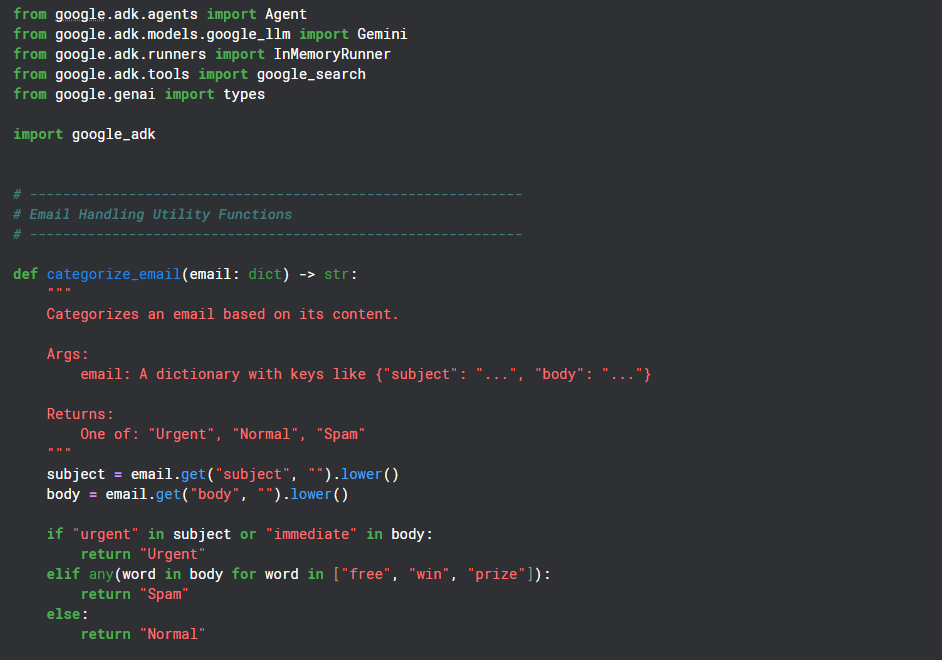

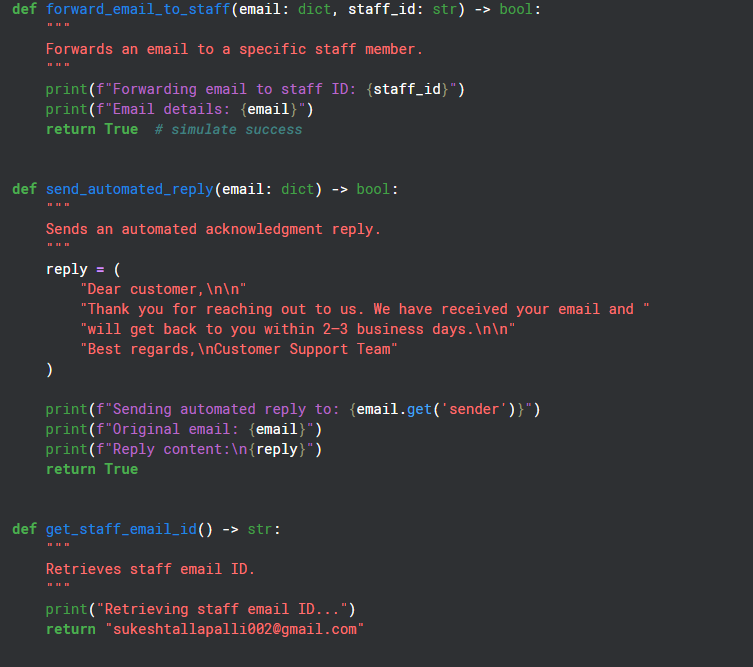

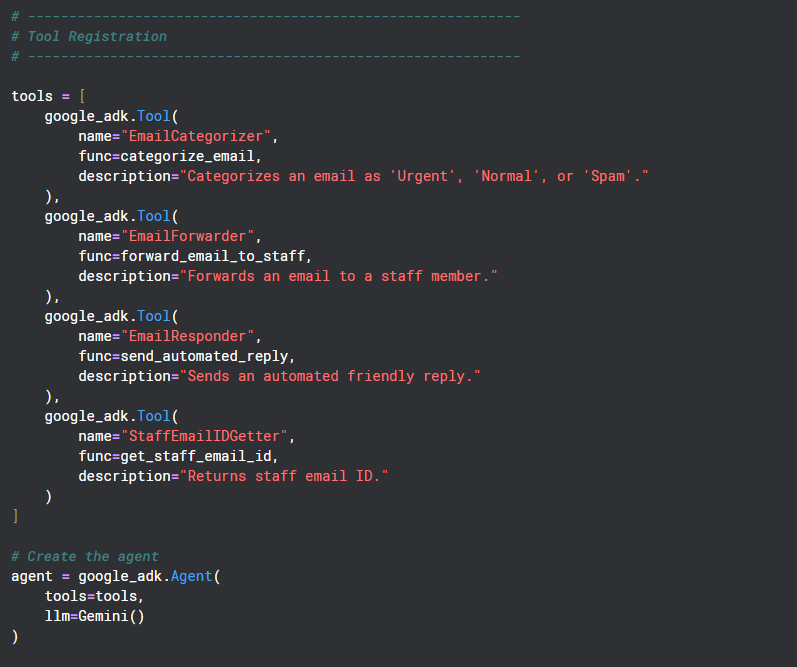

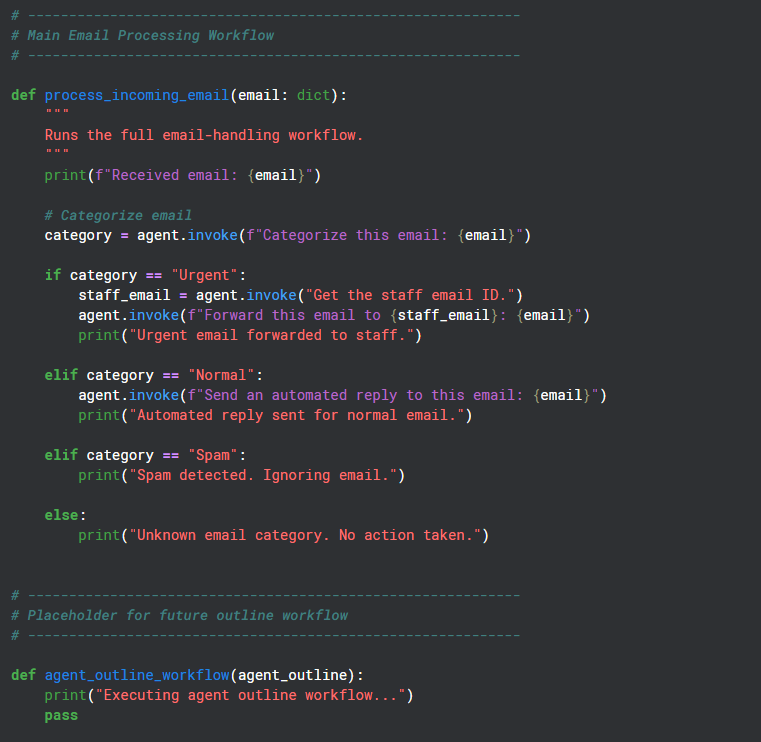


### Section 6: Conclusion
While the current implementation of 36Labs is fully functional, the generated code still exhibits occasional formatting inconsistencies and import-related issues. Addressing this will require scaling the system to support parallel execution with multiple agents. In future, 36Labs can scale into a production-grade framework with the integration of MCP servers, observability and agent-evaluation pipelines, and improved cross-agent orchestration. With the state-of-the-art models such as Gemini 3.0, the platform can gain major enhancements in reliability and performance, enabling more precise, efficient, and fully autonomous agent creation.

Thank you for reading the notebook and coming this far! Let me leave you with an ice-breaker:

_“AI keeps getting smarter — but some models still think the best **dessert** in the world is the Sahara.”_

